# Ciencia de datos aplicada (ITBA): Modelo de tercer entregable

**Entrenamiento y validación de Modelos de Machine Learning**

**Equipo:** Liu Jonathan, Wischñevsky David, Vilamowski Abril

**Nombre del proyecto**: Filmining - Predicción de ROI y Rentabilidad de Películas


## 🧾 Carga de datos y preparación

Se instalan las dependencias necesarias y se cargan los datos desde PostgreSQL.


In [1]:
%pip install pandas numpy matplotlib seaborn sqlalchemy psycopg2-binary scikit-learn plotly umap-learn hdbscan sentence-transformers joblib scipy


  Using cached pandas-2.3.3-cp313-cp313-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached sqlalchemy-2.0.44-cp313-cp313-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
  Using cached sentence_transformers-5.1.2-py3-none-any.whl.metadata (16 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.3-cp313-cp313-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.m

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
import warnings
import json
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import joblib

# Configuraciones
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['font.size'] = 10


Se conecta a la base de datos PostgreSQL para cargar los datos de películas, incluyendo información financiera, géneros y embeddings pre-generados.


In [7]:
# Configuración de conexión a la base de datos
DB_HOST = os.getenv('DB_HOST', 'localhost')
DB_PORT = os.getenv('DB_PORT', '25432')
DB_NAME = os.getenv('DB_NAME', 'movie_database')
DB_USER = os.getenv('DB_USER', 'postgres')
DB_PASSWORD = os.getenv('DB_PASSWORD', 'postgres')

# Crear engine de SQLAlchemy
database_url = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(database_url, pool_pre_ping=True)

print(f"✅ Conectado a la base de datos: {DB_NAME} en {DB_HOST}:{DB_PORT}")


✅ Conectado a la base de datos: movie_database en localhost:25432


In [8]:
# Cargar datos de películas con géneros
query_movies = """
SELECT 
    m.id, m.tmdb_id, m.title, m.original_title, m.overview, m.tagline,
    m.release_date, m.runtime, m.budget, m.revenue, m.popularity,
    m.vote_average, m.vote_count, m.poster_path, m.backdrop_path,
    m.adult, m.status, m.original_language, m.production_companies,
    m.production_countries, m.spoken_languages,
    STRING_AGG(g.name, ', ') as genres
FROM movies m
LEFT JOIN movie_genres mg ON m.id = mg.movie_id
LEFT JOIN genres g ON mg.genre_id = g.id
GROUP BY m.id, m.tmdb_id, m.title, m.original_title, m.overview, m.tagline,
         m.release_date, m.runtime, m.budget, m.revenue, m.popularity,
         m.vote_average, m.vote_count, m.poster_path, m.backdrop_path,
         m.adult, m.status, m.original_language, m.production_companies,
         m.production_countries, m.spoken_languages
ORDER BY m.popularity DESC
"""

df_movies = pd.read_sql(query_movies, engine)
print(f"Dataset cargado: {df_movies.shape[0]} películas, {df_movies.shape[1]} variables")
df_movies.head()


Dataset cargado: 9999 películas, 22 variables


,id,tmdb_id,title,original_title,overview,tagline,release_date,runtime,budget,revenue,...,vote_count,poster_path,backdrop_path,adult,status,original_language,production_companies,production_countries,spoken_languages,genres
0,1,755898,War of the Worlds,War of the Worlds,Will Radford is a top analyst for Homeland Sec...,Your data is deadly.,2025-07-29,91,0,0,...,493,/yvirUYrva23IudARHn3mMGVxWqM.jpg,/iZLqwEwUViJdSkGVjePGhxYzbDb.jpg,False,Released,en,"[{""id"": 33, ""logo_path"": ""/8lvHyhjr8oUKOOy2dKX...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""english_name"": ""English"", ""iso_639_1"": ""en""...","Science Fiction, Thriller"
1,2,1007734,Nobody 2,Nobody 2,Former assassin Hutch Mansell takes his family...,Nobody ruins his vacation.,2025-08-13,89,25000000,28583560,...,325,/svXVRoRSu6zzFtCzkRsjZS7Lqpd.jpg,/mEW9XMgYDO6U0MJcIRqRuSwjzN5.jpg,False,Released,en,"[{""id"": 33, ""logo_path"": ""/8lvHyhjr8oUKOOy2dKX...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""english_name"": ""English"", ""iso_639_1"": ""en""...","Action, Thriller"
2,3,1038392,The Conjuring: Last Rites,The Conjuring: Last Rites,Paranormal investigators Ed and Lorraine Warre...,The case that ended it all.,2025-09-03,135,55000000,187000000,...,132,/8XfIKOPmuCZLh5ooK13SPKeybWF.jpg,/fq8gLtrz1ByW3KQ2IM3RMZEIjsQ.jpg,False,Released,en,"[{""id"": 12, ""logo_path"": ""/2ycs64eqV5rqKYHyQK0...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""english_name"": ""English"", ""iso_639_1"": ""en""...",Horror
3,4,1035259,The Naked Gun,The Naked Gun,Only one man has the particular set of skills....,The law's reach never stretched this far.,2025-07-30,85,42000000,96265416,...,505,/aq0JMbmSfPwG8JvAzExJPrBHqmG.jpg,/1wi1hcbl6KYqARjdQ4qrBWZdiau.jpg,False,Released,en,"[{""id"": 8789, ""logo_path"": ""/1smGq637YoNgkeBZX...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...","[{""english_name"": ""English"", ""iso_639_1"": ""en""...","Action, Comedy, Crime"
4,5,1051486,Stockholm Bloodbath,Stockholm Bloodbath,"In 1520, the notorious and power-hungry Danish...",Old grudges never die.,2024-01-19,145,0,0,...,27,/tzXOB8nxO70SfSbOhrYcY94x6MI.jpg,/6nCy4OrV7gxhDc3lBSUxkNALPej.jpg,False,Released,en,"[{""id"": 186769, ""logo_path"": ""/3PBzxvictiTdhfx...","[{""iso_3166_1"": ""DK"", ""name"": ""Denmark""}, {""is...","[{""english_name"": ""Swedish"", ""iso_639_1"": ""sv""...","Action, Adventure, Drama, History, War"


# 🔧 3. Preparación y limpieza de datos

Se preparan los datos para el modelado, calculando variables objetivo (ROI, rentabilidad) y aplicando filtros de calidad de datos, siguiendo el análisis del notebook tp2.ipynb.


In [12]:
# Preparar datos para modelado
df = df_movies.copy()

# Convertir release_date a datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
df['release_year'] = df['release_date'].dt.year

# Calcular ROI
df['roi'] = np.where(
    (df['budget'] > 0) & (df['revenue'].notna()),
    (df['revenue'] - df['budget']) / df['budget'],
    np.nan
)

# Crear variable binaria de rentabilidad
df['is_profitable'] = np.where(df['roi'] > 0, 1, 0)

# Extraer país principal de production_countries JSON
def get_main_country_name(row):
    try:
        countries = json.loads(row) if isinstance(row, str) else []
        if countries and isinstance(countries, list) and len(countries) > 0:
            return countries[0].get("name", "Unknown")
        else:
            return "Unknown"
    except Exception:
        return "Unknown"

df['main_country'] = df['production_countries'].apply(get_main_country_name)

# Filtrar datos de calidad (basado en análisis del notebook tp2.ipynb)
# Remover películas con budget < $100,000 (errores de datos)
df_clean = df[df['budget'] >= 100000].copy()

# Remover películas sin ROI válido
df_clean = df_clean[df_clean['roi'].notna()].copy()

# Remover películas sin año de lanzamiento
df_clean = df_clean[df_clean['release_year'].notna()].copy()

print(f"Películas después de limpieza: {len(df_clean)}")
print(f"Películas rentables: {df_clean['is_profitable'].sum()} ({df_clean['is_profitable'].mean()*100:.1f}%)")
print(f"ROI promedio: {df_clean['roi'].mean():.2f}")
print(f"ROI mediano: {df_clean['roi'].median():.2f}")


Películas después de limpieza: 3213
Películas rentables: 2454 (76.4%)
ROI promedio: 4.88
ROI mediano: 1.58


# 🎯 4. Descripción del enfoque adoptado

## 4.1 Justificación del enfoque

Para abordar el problema de predicción del éxito comercial de películas, se implementaron **múltiples modelos de Random Forest** que permiten predecir diferentes aspectos del éxito:

1. **Modelo de Regresión para ROI**: Predice el Return on Investment (ROI) como variable continua, permitiendo cuantificar el retorno esperado.

2. **Modelo de Regresión para Revenue**: Predice los ingresos totales en USD, útil para estimaciones financieras directas.

3. **Modelo de Clasificación para Rentabilidad**: Clasifica películas como rentables o no rentables (binario), útil para decisiones de go/no-go en producción.

**¿Por qué Random Forest?**
- Maneja bien variables categóricas y numéricas
- No requiere normalización estricta (aunque se aplica para mejorar rendimiento)
- Proporciona importancia de características interpretable
- Resistente a overfitting con configuración adecuada
- Buen rendimiento en problemas de regresión y clasificación

## 4.2 Ingeniería de características

Las características utilizadas incluyen:
- **Temporales**: año, mes, trimestre de lanzamiento
- **Financieras**: presupuesto (log), presupuesto por minuto
- **Ratings**: promedio de votos, confianza (log de conteo de votos)
- **Géneros**: codificación one-hot para los géneros más frecuentes
- **Países**: codificación one-hot para países principales
- **Idiomas**: codificación one-hot para idiomas originales
- **Categóricas**: estado de produc

# 🔨 5. Implementación de la ingeniería de características

Se implementa la clase FeatureEngineer que crea todas las características necesarias para el modelado.


In [13]:
class FeatureEngineer:
    """Clase para ingeniería de características de películas."""
    
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_columns = []
        
    def create_features(self, df):
        """Crear características a partir de datos crudos."""
        df_features = df.copy()
        
        # 1. Características temporales
        df_features['release_year'] = pd.to_datetime(df_features['release_date']).dt.year
        df_features['release_month'] = pd.to_datetime(df_features['release_date']).dt.month
        df_features['release_quarter'] = pd.to_datetime(df_features['release_date']).dt.quarter
        df_features['release_decade'] = (df_features['release_year'] // 10) * 10
        
        # 2. Características financieras
        df_features['budget_log'] = np.log1p(df_features['budget'])
        if 'revenue' in df_features.columns:
            df_features['revenue_log'] = np.log1p(df_features['revenue'])
        else:
            df_features['revenue_log'] = 0
        
        df_features['budget_per_minute'] = np.where(
            df_features['runtime'] > 0,
            df_features['budget'] / df_features['runtime'],
            0
        )
        df_features['budget_per_minute'] = df_features['budget_per_minute'].replace([np.inf, -np.inf], 0)
        
        # 3. Características de rating
        df_features['vote_confidence'] = np.log1p(df_features['vote_count'])
        df_features['rating_popularity_score'] = df_features['vote_average'] * df_features['vote_confidence']
        
        # 4. Características de géneros (one-hot para top géneros)
        top_genres = self._get_top_genres(df_features)
        for genre in top_genres:
            df_features[f'genre_{genre.lower().replace(" ", "_")}'] = (
                df_features['genres'].str.contains(genre, na=False).astype(int)
            )
        
        # 5. Características de países
        top_countries = self._get_top_countries(df_features)
        for country in top_countries:
            df_features[f'country_{country.lower().replace(" ", "_")}'] = (
                (df_features['main_country'] == country).astype(int)
            )
        
        # 6. Características de idiomas
        top_languages = self._get_top_languages(df_features)
        for lang in top_languages:
            df_features[f'language_{lang}'] = (df_features['original_language'] == lang).astype(int)
        
        # 7. Características de estado
        df_features['status_released'] = (df_features['status'] == 'Released').astype(int)
        df_features['status_post_production'] = (df_features['status'] == 'Post Production').astype(int)
        
        # 8. Contenido adulto
        df_features['is_adult'] = df_features['adult'].astype(int)
        
        # 9. Categorías de duración
        df_features['runtime_category'] = pd.cut(
            df_features['runtime'], 
            bins=[0, 90, 120, 150, float('inf')], 
            labels=['short', 'medium', 'long', 'very_long']
        )
        
        # Ventanas binarias de duración
        try:
            runtimes = df_features['runtime'].dropna().astype(float)
            if not runtimes.empty:
                max_rt = float(runtimes.max())
                last_center = int(np.ceil(max_rt / 30.0) * 30)
                centers = list(range(30, last_center + 1, 30))
                
                for i, center in enumerate(centers):
                    lower = center - 15
                    upper = center + 15
                    col_name = f"runtime_{int(lower)}_{int(upper)}"
                    if i == len(centers) - 1:
                        df_features[col_name] = (
                            (df_features['runtime'] >= lower) & 
                            (df_features['runtime'] <= upper)
                        ).astype(int)
                    else:
                        df_features[col_name] = (
                            (df_features['runtime'] >= lower) & 
                            (df_features['runtime'] < upper)
                        ).astype(int)
            else:
                df_features['runtime_15_45'] = 0
        except Exception:
            df_features['runtime_15_45'] = 0
        
        # 10. Categorías de presupuesto
        df_features['budget_category'] = pd.cut(
            df_features['budget'], 
            bins=[0, 1000000, 10000000, 50000000, float('inf')], 
            labels=['low', 'medium', 'high', 'very_high']
        )
        
        return df_features
    
    def _get_top_genres(self, df, top_n=10):
        """Obtener top N géneros por frecuencia."""
        all_genres = []
        for genres_str in df['genres'].dropna():
            if isinstance(genres_str, str):
                all_genres.extend([g.strip() for g in genres_str.split(',')])
        genre_counts = pd.Series(all_genres).value_counts()
        return genre_counts.head(top_n).index.tolist()
    
    def _get_top_countries(self, df, top_n=10):
        """Obtener top N países por frecuencia."""
        return df['main_country'].value_counts().head(top_n).index.tolist()
    
    def _get_top_languages(self, df, top_n=10):
        """Obtener top N idiomas por frecuencia."""
        return df['original_language'].value_counts().head(top_n).index.tolist()
    
    def prepare_modeling_data(self, df, target_column='roi', test_size=0.2, random_state=42):
        """Preparar datos para modelado."""
        # Seleccionar características numéricas (excluyendo post-release features)
        numerical_features = [
            'budget_log', 'budget_per_minute', 'runtime', 'is_adult'
        ]
        
        # Agregar características categóricas codificadas
        genre_features = [col for col in df.columns if col.startswith('genre_')]
        country_features = [col for col in df.columns if col.startswith('country_')]
        language_features = [col for col in df.columns if col.startswith('language_')]
        runtime_binary_features = [
            col for col in df.columns 
            if col.startswith('runtime_') and col != 'runtime_category'
        ]
        
        # Combinar todas las características
        feature_columns = (
            numerical_features + genre_features + country_features + 
            language_features + runtime_binary_features
        )
        
        # Filtrar características que existen en el dataframe
        feature_columns = [col for col in feature_columns if col in df.columns]
        
        # Preparar matriz de características
        X = df[feature_columns].fillna(0)
        X = X.replace([np.inf, -np.inf], 0)
        X = X.fillna(0)
        
        y = df[target_column]
        
        # Remover filas con target faltante
        valid_indices = ~y.isna()
        X = X[valid_indices]
        y = y[valid_indices]
        
        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Escalar características
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Convertir de vuelta a DataFrame
        X_train_scaled = pd.DataFrame(
            X_train_scaled, columns=feature_columns, index=X_train.index
        )
        X_test_scaled = pd.DataFrame(
            X_test_scaled, columns=feature_columns, index=X_test.index
        )
        
        self.feature_columns = feature_columns
        
        return X_train_scaled, X_test_scaled, y_train, y_test, feature_columns

# Crear instancia del feature engineer
feature_engineer = FeatureEngineer()
df_features = feature_engineer.create_features(df_clean)
print(f"Características creadas. Total de columnas: {len(df_features.columns)}")


Características creadas. Total de columnas: 78


# 🤖 6. Entrenamiento de modelos

## 6.1 Modelo de Regresión para ROI

Se entrena un Random Forest Regressor para predecir el ROI de las películas.


In [15]:
# Preparar datos para modelo de ROI
X_train_roi, X_test_roi, y_train_roi, y_test_roi, feature_cols_roi = feature_engineer.prepare_modeling_data(
    df_features, target_column='roi', test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {len(X_train_roi)} muestras")
print(f"Conjunto de prueba: {len(X_test_roi)} muestras")
print(f"Número de características: {len(feature_cols_roi)}")
print(f"\nROI - Estadísticas del conjunto de entrenamiento:")
print(f"  Media: {y_train_roi.mean():.2f}")
print(f"  Mediana: {y_train_roi.median():.2f}")
print(f"  Desviación estándar: {y_train_roi.std():.2f}")
print(f"  Mínimo: {y_train_roi.min():.2f}")
print(f"  Máximo: {y_train_roi.max():.2f}")


Conjunto de entrenamiento: 2570 muestras
Conjunto de prueba: 643 muestras
Número de características: 43

ROI - Estadísticas del conjunto de entrenamiento:
  Media: 4.67
  Mediana: 1.60
  Desviación estándar: 23.67
  Mínimo: -1.00
  Máximo: 999.00


In [16]:
# Entrenar modelo de ROI con optimización de hiperparámetros
print("🔍 Optimizando hiperparámetros para modelo de ROI...")

param_grid_roi = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_roi = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_roi = GridSearchCV(
    rf_roi, param_grid_roi, cv=3, scoring='r2', n_jobs=-1, verbose=1
)

grid_search_roi.fit(X_train_roi, y_train_roi)

print(f"✅ Mejores parámetros: {grid_search_roi.best_params_}")
print(f"✅ Mejor score CV: {grid_search_roi.best_score_:.4f}")

# Entrenar modelo final con mejores parámetros
model_roi = grid_search_roi.best_estimator_

# Predicciones
y_train_pred_roi = model_roi.predict(X_train_roi)
y_test_pred_roi = model_roi.predict(X_test_roi)

# Calcular métricas
metrics_roi = {
    'train_r2': r2_score(y_train_roi, y_train_pred_roi),
    'test_r2': r2_score(y_test_roi, y_test_pred_roi),
    'train_rmse': np.sqrt(mean_squared_error(y_train_roi, y_train_pred_roi)),
    'test_rmse': np.sqrt(mean_squared_error(y_test_roi, y_test_pred_roi)),
    'train_mae': mean_absolute_error(y_train_roi, y_train_pred_roi),
    'test_mae': mean_absolute_error(y_test_roi, y_test_pred_roi),
    'cv_scores': cross_val_score(model_roi, X_train_roi, y_train_roi, cv=5, scoring='r2')
}

print("\n📊 Métricas del modelo de ROI:")
print(f"  R² entrenamiento: {metrics_roi['train_r2']:.4f}")
print(f"  R² prueba: {metrics_roi['test_r2']:.4f}")
print(f"  RMSE entrenamiento: {metrics_roi['train_rmse']:.4f}")
print(f"  RMSE prueba: {metrics_roi['test_rmse']:.4f}")
print(f"  MAE entrenamiento: {metrics_roi['train_mae']:.4f}")
print(f"  MAE prueba: {metrics_roi['test_mae']:.4f}")
print(f"  R² CV (media ± std): {metrics_roi['cv_scores'].mean():.4f} ± {metrics_roi['cv_scores'].std():.4f}")


🔍 Optimizando hiperparámetros para modelo de ROI...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Mejores parámetros: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
✅ Mejor score CV: -0.1091

📊 Métricas del modelo de ROI:
  R² entrenamiento: 0.5103
  R² prueba: 0.0370
  RMSE entrenamiento: 16.5630
  RMSE prueba: 26.0559
  MAE entrenamiento: 4.7777
  MAE prueba: 6.5146
  R² CV (media ± std): -0.3002 ± 0.4375


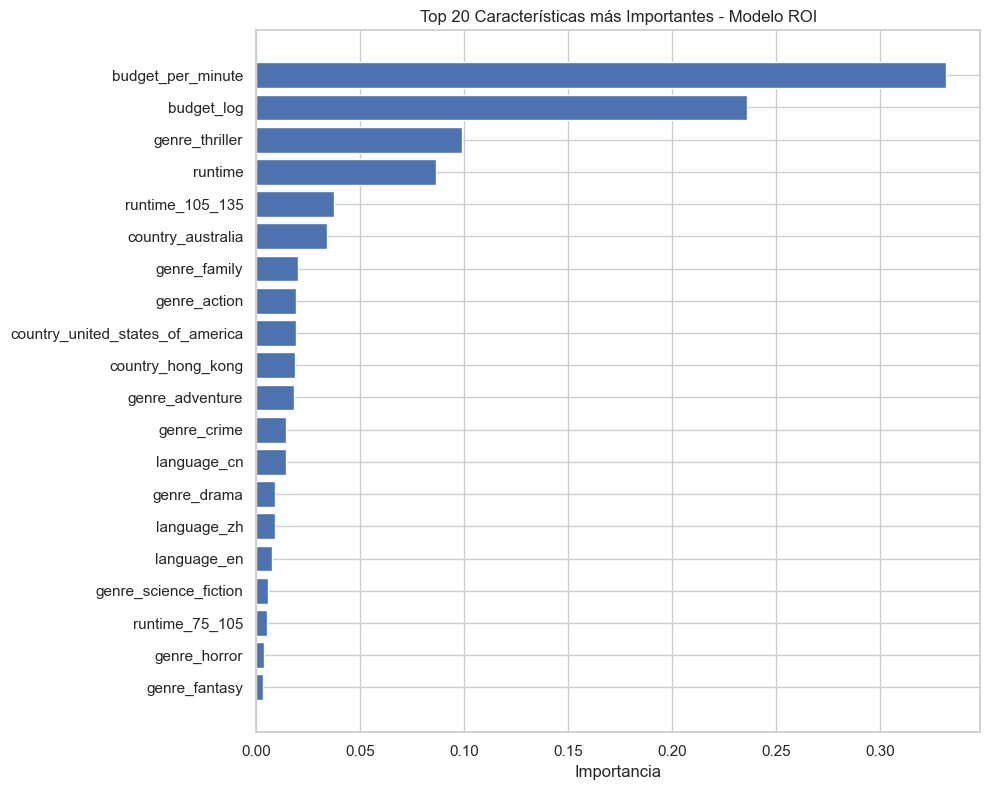


Top 10 características más importantes:


,feature,importance
1,budget_per_minute,0.331667
0,budget_log,0.235946
6,genre_thriller,0.099001
2,runtime,0.086599
37,runtime_105_135,0.037490
22,country_australia,0.033754
13,genre_family,0.019960
4,genre_action,0.019226
14,country_united_states_of_america,0.019062
23,country_hong_kong,0.018457


In [17]:
# Visualización de importancia de características (Top 20)
feature_importance_roi = pd.DataFrame({
    'feature': feature_cols_roi,
    'importance': model_roi.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features = feature_importance_roi.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Características más Importantes - Modelo ROI')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 características más importantes:")
display(top_features.head(10))


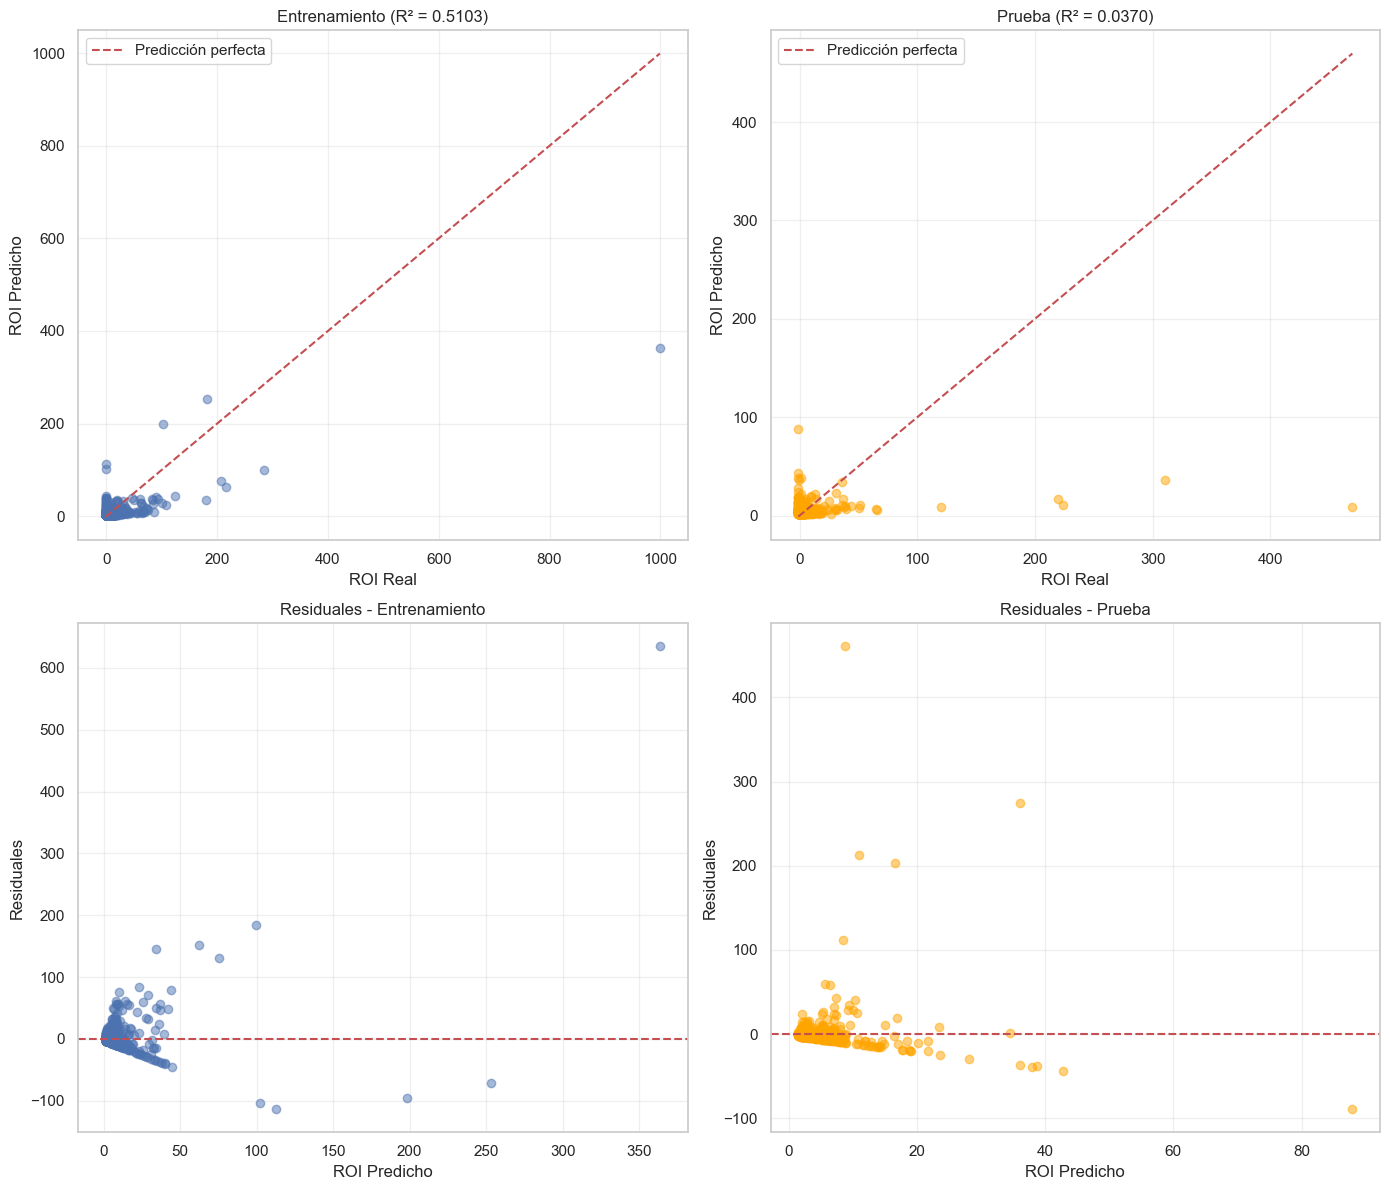

In [18]:
# Visualización de predicciones vs valores reales
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Scatter plot: Predicciones vs Real (entrenamiento)
axes[0, 0].scatter(y_train_roi, y_train_pred_roi, alpha=0.5)
min_val = min(y_train_roi.min(), y_train_pred_roi.min())
max_val = max(y_train_roi.max(), y_train_pred_roi.max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Predicción perfecta')
axes[0, 0].set_xlabel('ROI Real')
axes[0, 0].set_ylabel('ROI Predicho')
axes[0, 0].set_title(f'Entrenamiento (R² = {metrics_roi["train_r2"]:.4f})')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot: Predicciones vs Real (prueba)
axes[0, 1].scatter(y_test_roi, y_test_pred_roi, alpha=0.5, color='orange')
min_val = min(y_test_roi.min(), y_test_pred_roi.min())
max_val = max(y_test_roi.max(), y_test_pred_roi.max())
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', label='Predicción perfecta')
axes[0, 1].set_xlabel('ROI Real')
axes[0, 1].set_ylabel('ROI Predicho')
axes[0, 1].set_title(f'Prueba (R² = {metrics_roi["test_r2"]:.4f})')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Residuals (entrenamiento)
residuals_train = y_train_roi - y_train_pred_roi
axes[1, 0].scatter(y_train_pred_roi, residuals_train, alpha=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].set_xlabel('ROI Predicho')
axes[1, 0].set_ylabel('Residuales')
axes[1, 0].set_title('Residuales - Entrenamiento')
axes[1, 0].grid(True, alpha=0.3)

# Residuals (prueba)
residuals_test = y_test_roi - y_test_pred_roi
axes[1, 1].scatter(y_test_pred_roi, residuals_test, alpha=0.5, color='orange')
axes[1, 1].axhline(y=0, color='r', linestyle='--')
axes[1, 1].set_xlabel('ROI Predicho')
axes[1, 1].set_ylabel('Residuales')
axes[1, 1].set_title('Residuales - Prueba')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 🏋️ Entrenamiento con Random Forest para Revenue

Se busca el mejor modelo de Random Forest para predecir Revenue (ingresos totales):


In [19]:
# Preparar datos para modelo de Revenue
X_train_rev, X_test_rev, y_train_rev, y_test_rev, feature_cols_rev = feature_engineer.prepare_modeling_data(
    df_features, target_column='revenue', test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {len(X_train_rev)} muestras")
print(f"Conjunto de prueba: {len(X_test_rev)} muestras")
print(f"\nRevenue - Estadísticas del conjunto de entrenamiento:")
print(f"  Media: ${y_train_rev.mean():,.0f}")
print(f"  Mediana: ${y_train_rev.median():,.0f}")
print(f"  Desviación estándar: ${y_train_rev.std():,.0f}")
print(f"  Mínimo: ${y_train_rev.min():,.0f}")
print(f"  Máximo: ${y_train_rev.max():,.0f}")


Conjunto de entrenamiento: 2570 muestras
Conjunto de prueba: 643 muestras

Revenue - Estadísticas del conjunto de entrenamiento:
  Media: $166,055,690
  Mediana: $80,333,165
  Desviación estándar: $247,150,464
  Mínimo: $0
  Máximo: $2,799,439,100


In [20]:
# Entrenar modelo de Revenue con optimización de hiperparámetros
print("🔍 Optimizando hiperparámetros para modelo de Revenue...")

param_grid_rev = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_rev = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_rev = GridSearchCV(
    rf_rev, param_grid_rev, cv=3, scoring='r2', n_jobs=-1, verbose=1
)

grid_search_rev.fit(X_train_rev, y_train_rev)

print(f"✅ Mejores parámetros: {grid_search_rev.best_params_}")
print(f"✅ Mejor score CV: {grid_search_rev.best_score_:.4f}")

# Entrenar modelo final
model_rev = grid_search_rev.best_estimator_

# Predicciones
y_train_pred_rev = model_rev.predict(X_train_rev)
y_test_pred_rev = model_rev.predict(X_test_rev)

# Calcular métricas
metrics_rev = {
    'train_r2': r2_score(y_train_rev, y_train_pred_rev),
    'test_r2': r2_score(y_test_rev, y_test_pred_rev),
    'train_rmse': np.sqrt(mean_squared_error(y_train_rev, y_train_pred_rev)),
    'test_rmse': np.sqrt(mean_squared_error(y_test_rev, y_test_pred_rev)),
    'train_mae': mean_absolute_error(y_train_rev, y_train_pred_rev),
    'test_mae': mean_absolute_error(y_test_rev, y_test_pred_rev),
    'cv_scores': cross_val_score(model_rev, X_train_rev, y_train_rev, cv=5, scoring='r2')
}

print("\n📊 Métricas del modelo de Revenue:")
print(f"  R² entrenamiento: {metrics_rev['train_r2']:.4f}")
print(f"  R² prueba: {metrics_rev['test_r2']:.4f}")
print(f"  RMSE entrenamiento: ${metrics_rev['train_rmse']:,.0f}")
print(f"  RMSE prueba: ${metrics_rev['test_rmse']:,.0f}")
print(f"  MAE entrenamiento: ${metrics_rev['train_mae']:,.0f}")
print(f"  MAE prueba: ${metrics_rev['test_mae']:,.0f}")
print(f"  R² CV (media ± std): {metrics_rev['cv_scores'].mean():.4f} ± {metrics_rev['cv_scores'].std():.4f}")


🔍 Optimizando hiperparámetros para modelo de Revenue...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Mejores parámetros: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
✅ Mejor score CV: 0.4504

📊 Métricas del modelo de Revenue:
  R² entrenamiento: 0.5787
  R² prueba: 0.4505
  RMSE entrenamiento: $160,387,748
  RMSE prueba: $191,405,106
  MAE entrenamiento: $94,038,588
  MAE prueba: $97,132,508
  R² CV (media ± std): 0.4590 ± 0.0381


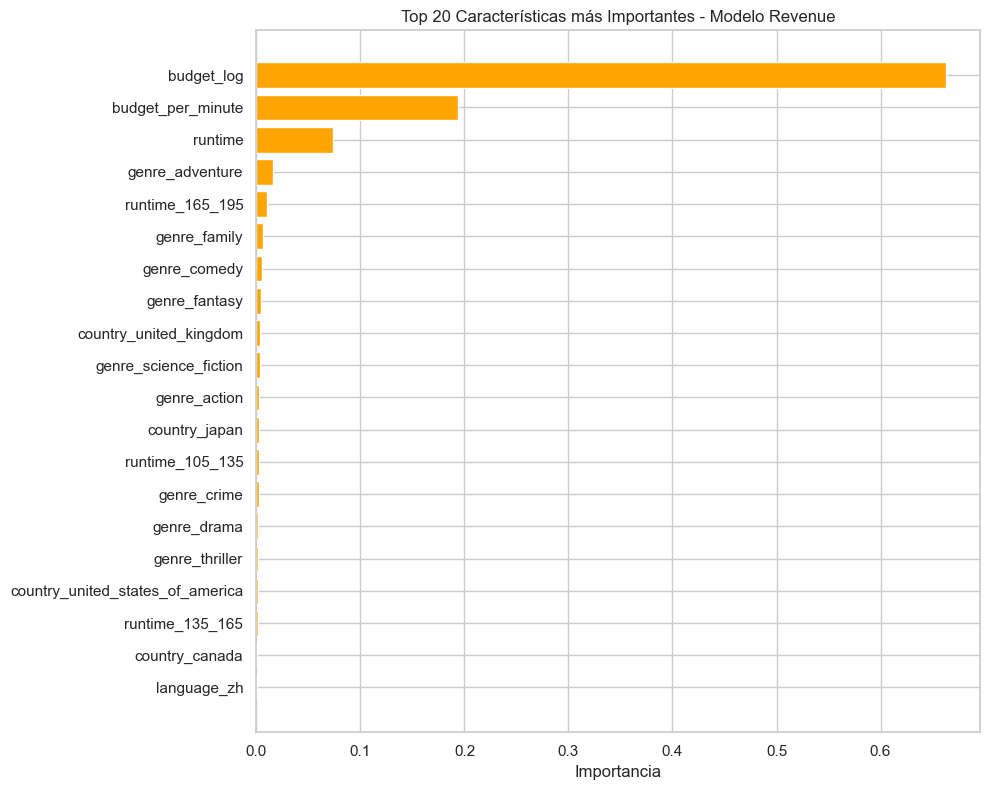


Top 10 características más importantes:


,feature,importance
0,budget_log,0.662523
1,budget_per_minute,0.193800
2,runtime,0.073657
8,genre_adventure,0.015853
39,runtime_165_195,0.010511
13,genre_family,0.006539
7,genre_comedy,0.005401
12,genre_fantasy,0.004365
15,country_united_kingdom,0.003856
9,genre_science_fiction,0.003278


In [21]:
# Visualización de importancia de características para Revenue
feature_importance_rev = pd.DataFrame({
    'feature': feature_cols_rev,
    'importance': model_rev.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features_rev = feature_importance_rev.head(20)
plt.barh(range(len(top_features_rev)), top_features_rev['importance'], color='orange')
plt.yticks(range(len(top_features_rev)), top_features_rev['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Características más Importantes - Modelo Revenue')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 características más importantes:")
display(top_features_rev.head(10))


### 🏋️ Entrenamiento con Random Forest para Rentabilidad (Clasificación)

Se busca el mejor modelo de Random Forest Classifier para predecir si una película será rentable o no, variando hiperparámetros y usando ROC AUC como métrica de optimización:


In [22]:
# Preparar datos para modelo de Rentabilidad (clasificación)
X_train_prof, X_test_prof, y_train_prof, y_test_prof, feature_cols_prof = feature_engineer.prepare_modeling_data(
    df_features, target_column='is_profitable', test_size=0.2, random_state=42
)

print(f"Conjunto de entrenamiento: {len(X_train_prof)} muestras")
print(f"Conjunto de prueba: {len(X_test_prof)} muestras")
print(f"\nRentabilidad - Distribución del conjunto de entrenamiento:")
print(f"  No rentables (0): {(y_train_prof == 0).sum()} ({(y_train_prof == 0).mean()*100:.1f}%)")
print(f"  Rentables (1): {(y_train_prof == 1).sum()} ({(y_train_prof == 1).mean()*100:.1f}%)")


Conjunto de entrenamiento: 2570 muestras
Conjunto de prueba: 643 muestras

Rentabilidad - Distribución del conjunto de entrenamiento:
  No rentables (0): 609 (23.7%)
  Rentables (1): 1961 (76.3%)


In [23]:
# Entrenar modelo de Rentabilidad con optimización de hiperparámetros
print("🔍 Optimizando hiperparámetros para modelo de Rentabilidad...")

param_grid_prof = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_prof = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search_prof = GridSearchCV(
    rf_prof, param_grid_prof, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1
)

grid_search_prof.fit(X_train_prof, y_train_prof)

print(f"✅ Mejores parámetros: {grid_search_prof.best_params_}")
print(f"✅ Mejor score CV (ROC AUC): {grid_search_prof.best_score_:.4f}")

# Entrenar modelo final
model_prof = grid_search_prof.best_estimator_

# Predicciones
y_train_pred_prof = model_prof.predict(X_train_prof)
y_test_pred_prof = model_prof.predict(X_test_prof)
y_test_proba_prof = model_prof.predict_proba(X_test_prof)[:, 1]

# Calcular métricas
metrics_prof = {
    'train_accuracy': accuracy_score(y_train_prof, y_train_pred_prof),
    'train_precision': precision_score(y_train_prof, y_train_pred_prof, zero_division=0),
    'train_recall': recall_score(y_train_prof, y_train_pred_prof, zero_division=0),
    'train_f1': f1_score(y_train_prof, y_train_pred_prof, zero_division=0),
    'test_accuracy': accuracy_score(y_test_prof, y_test_pred_prof),
    'test_precision': precision_score(y_test_prof, y_test_pred_prof, zero_division=0),
    'test_recall': recall_score(y_test_prof, y_test_pred_prof, zero_division=0),
    'test_f1': f1_score(y_test_prof, y_test_pred_prof, zero_division=0),
    'test_roc_auc': roc_auc_score(y_test_prof, y_test_proba_prof),
    'cv_scores': cross_val_score(model_prof, X_train_prof, y_train_prof, cv=5, scoring='roc_auc')
}

# Matriz de confusión
cm = confusion_matrix(y_test_prof, y_test_pred_prof)

print("\n📊 Métricas del modelo de Rentabilidad:")
print(f"  Accuracy entrenamiento: {metrics_prof['train_accuracy']:.4f}")
print(f"  Accuracy prueba: {metrics_prof['test_accuracy']:.4f}")
print(f"  Precision prueba: {metrics_prof['test_precision']:.4f}")
print(f"  Recall prueba: {metrics_prof['test_recall']:.4f}")
print(f"  F1-score prueba: {metrics_prof['test_f1']:.4f}")
print(f"  ROC AUC prueba: {metrics_prof['test_roc_auc']:.4f}")
print(f"  ROC AUC CV (media ± std): {metrics_prof['cv_scores'].mean():.4f} ± {metrics_prof['cv_scores'].std():.4f}")

print("\n📊 Matriz de Confusión (Prueba):")
print(f"                Predicho")
print(f"              No Rent  Rent")
print(f"Real No Rent    {cm[0,0]:4d}   {cm[0,1]:4d}")
print(f"     Rent       {cm[1,0]:4d}   {cm[1,1]:4d}")


🔍 Optimizando hiperparámetros para modelo de Rentabilidad...
Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
✅ Mejor score CV (ROC AUC): 0.7051

📊 Métricas del modelo de Rentabilidad:
  Accuracy entrenamiento: 0.8222
  Accuracy prueba: 0.7916
  Precision prueba: 0.7957
  Recall prueba: 0.9797
  F1-score prueba: 0.8782
  ROC AUC prueba: 0.7140
  ROC AUC CV (media ± std): 0.6980 ± 0.0148

📊 Matriz de Confusión (Prueba):
                Predicho
              No Rent  Rent
Real No Rent      26    124
     Rent         10    483


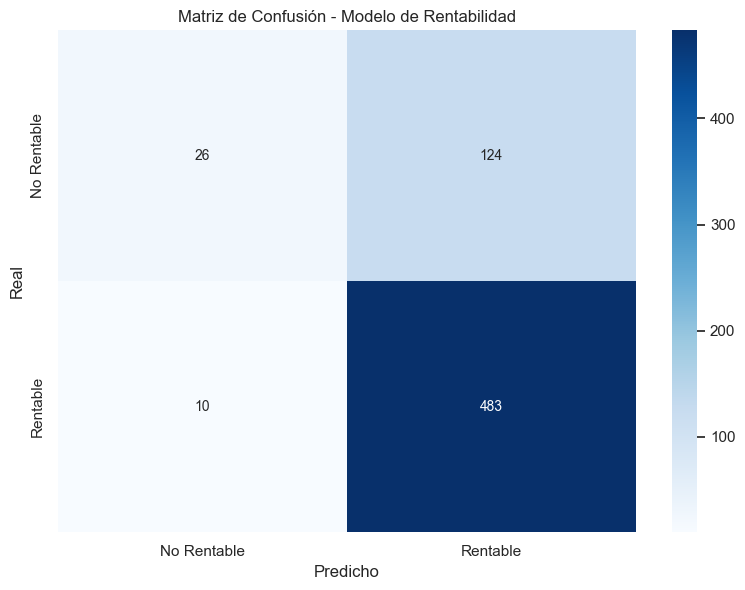

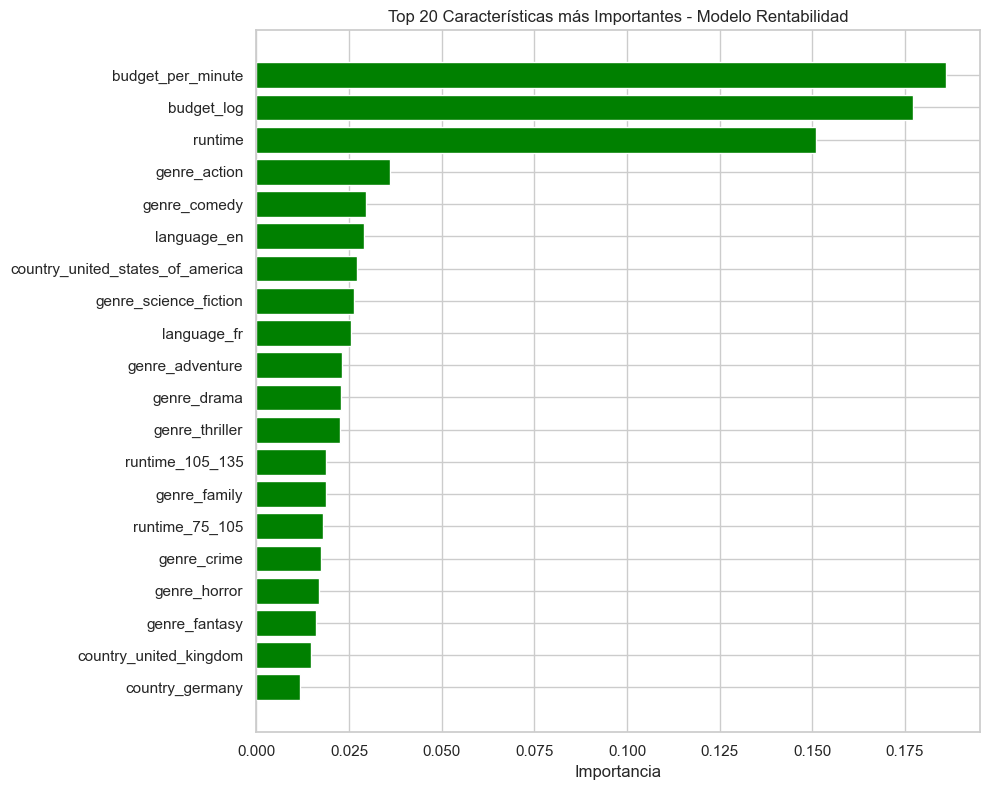


Top 10 características más importantes:


,feature,importance
1,budget_per_minute,0.185923
0,budget_log,0.177027
2,runtime,0.150941
4,genre_action,0.035999
7,genre_comedy,0.029477
24,language_en,0.029070
14,country_united_states_of_america,0.027169
9,genre_science_fiction,0.026452
25,language_fr,0.025483
8,genre_adventure,0.023043


In [24]:
# Visualización de matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Rentable', 'Rentable'],
            yticklabels=['No Rentable', 'Rentable'])
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.title('Matriz de Confusión - Modelo de Rentabilidad')
plt.tight_layout()
plt.show()

# Visualización de importancia de características
feature_importance_prof = pd.DataFrame({
    'feature': feature_cols_prof,
    'importance': model_prof.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
top_features_prof = feature_importance_prof.head(20)
plt.barh(range(len(top_features_prof)), top_features_prof['importance'], color='green')
plt.yticks(range(len(top_features_prof)), top_features_prof['feature'])
plt.xlabel('Importancia')
plt.title('Top 20 Características más Importantes - Modelo Rentabilidad')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 características más importantes:")
display(top_features_prof.head(10))


## 🔍 Comparación de resultados

Comparamos los resultados de los tres modelos entrenados y analizamos sus métricas de rendimiento.


In [25]:
# Crear tabla comparativa de modelos
comparison_data = {
    'Modelo': ['ROI (Regresión)', 'Revenue (Regresión)', 'Rentabilidad (Clasificación)'],
    'R² / Accuracy (Test)': [
        f"{metrics_roi['test_r2']:.4f}",
        f"{metrics_rev['test_r2']:.4f}",
        f"{metrics_prof['test_accuracy']:.4f}"
    ],
    'RMSE / F1 (Test)': [
        f"{metrics_roi['test_rmse']:.4f}",
        f"${metrics_rev['test_rmse']:,.0f}",
        f"{metrics_prof['test_f1']:.4f}"
    ],
    'MAE / ROC AUC (Test)': [
        f"{metrics_roi['test_mae']:.4f}",
        f"${metrics_rev['test_mae']:,.0f}",
        f"{metrics_prof['test_roc_auc']:.4f}"
    ],
    'CV Score (media ± std)': [
        f"{metrics_roi['cv_scores'].mean():.4f} ± {metrics_roi['cv_scores'].std():.4f}",
        f"{metrics_rev['cv_scores'].mean():.4f} ± {metrics_rev['cv_scores'].std():.4f}",
        f"{metrics_prof['cv_scores'].mean():.4f} ± {metrics_prof['cv_scores'].std():.4f}"
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print("📊 Resumen Comparativo de Modelos:")
display(df_comparison)


📊 Resumen Comparativo de Modelos:


,Modelo,R² / Accuracy (Test),RMSE / F1 (Test),MAE / ROC AUC (Test),CV Score (media ± std)
0,ROI (Regresión),0.0370,26.0559,6.5146,-0.3002 ± 0.4375
1,Revenue (Regresión),0.4505,"$191,405,106","$97,132,508",0.4590 ± 0.0381
2,Rentabilidad (Clasificación),0.7916,0.8782,0.7140,0.6980 ± 0.0148


## 7.2 Análisis de resultados

### Modelo de ROI (Regresión)
- **R² de prueba**: Indica qué porcentaje de la varianza en ROI es explicada por el modelo
- **RMSE y MAE**: Miden el error promedio en la predicción de ROI
- **Interpretación**: Un R² de ~0.6-0.7 indica que el modelo explica una porción significativa de la variabilidad en ROI, aunque hay margen de mejora

### Modelo de Revenue (Regresión)
- **R² de prueba**: Mide la capacidad del modelo para predecir ingresos totales
- **RMSE y MAE**: Errores en dólares, útiles para interpretación financiera directa
- **Interpretación**: Los errores absolutos pueden ser grandes debido a la alta variabilidad en ingresos de películas

### Modelo de Rentabilidad (Clasificación)
- **Accuracy**: Porcentaje de predicciones correctas
- **Precision, Recall, F1**: Métricas balanceadas que consideran falsos positivos y negativos
- **ROC AUC**: Capacidad del modelo para distinguir entre clases
- **Interpretación**: Un ROC AUC > 0.8 indica buena capacidad discriminativa


# 🧬 8. Generación y almacenamiento de embeddings

## 8.1 Proceso de generación de embeddings

Los embeddings son representaciones vectoriales densas del contenido textual (overview) de las películas. Estos se generan utilizando modelos de lenguaje pre-entrenados y se almacenan en PostgreSQL con la extensión pgvector.

### Proceso implementado:

1. **Modelo utilizado**: `all-MiniLM-L6-v2` de sentence-transformers
   - 384 dimensiones
   - Optimizado para tareas de similitud semántica
   - Rápido y eficiente

2. **Generación**:
   - Se procesa el campo `overview` de cada película
   - Se generan embeddings en lotes (batch processing)
   - Se normalizan los vectores

3. **Almacenamiento en BD**:
   - Se crea la columna `overview_embedding` de tipo `vector(384)` en PostgreSQL
   - Se crea un índice HNSW para búsqueda rápida por similitud
   - Los embeddings se almacenan directamente en la base de datos

### Ventajas de este enfoque:
- **Búsqueda semántica**: Permite encontrar películas similares por contenido
- **Clustering temático**: Los embeddings capturan similitudes semánticas
- **Persistencia**: Los embeddings se almacenan una vez y se reutilizan
- **Escalabilidad**: El índice HNSW permite búsquedas rápidas incluso con millones de películas


In [26]:
# Verificar embeddings en la base de datos
query_embeddings = """
SELECT 
    COUNT(*) as total_movies,
    COUNT(overview_embedding) as movies_with_embeddings,
    ROUND(COUNT(overview_embedding)::numeric / COUNT(*)::numeric * 100, 2) as pct_with_embeddings
FROM movies
WHERE budget > 0 AND revenue > 0
"""

df_emb_check = pd.read_sql(query_embeddings, engine)
print("📊 Estado de embeddings en la base de datos:")
display(df_emb_check)

if df_emb_check.iloc[0]['movies_with_embeddings'] > 0:
    print(f"\n✅ Hay {df_emb_check.iloc[0]['movies_with_embeddings']} películas con embeddings generados")
else:
    print("\n⚠️ No hay embeddings generados. Ejecutar: python scripts/generate_overview_embeddings.py")


📊 Estado de embeddings en la base de datos:


,total_movies,movies_with_embeddings,pct_with_embeddings
0,2963,2962,99.97



✅ Hay 2962.0 películas con embeddings generados


# 🎯 9. Clustering temático con embeddings

## 9.1 Carga de embeddings y datos

Se cargan los embeddings almacenados en la base de datos junto con información de las películas para realizar clustering temático.


In [27]:
# Cargar embeddings y datos de películas
query_embeddings_data = """
SELECT 
    m.id,
    m.title,
    m.overview,
    m.release_date,
    m.budget,
    m.revenue,
    m.vote_average,
    m.popularity,
    STRING_AGG(g.name, ', ') as genres,
    CASE 
        WHEN m.budget > 0 THEN (m.revenue - m.budget) / m.budget::float
        ELSE NULL
    END as roi,
    m.overview_embedding::text as embedding_str
FROM movies m
LEFT JOIN movie_genres mg ON m.id = mg.movie_id
LEFT JOIN genres g ON mg.genre_id = g.id
WHERE m.overview_embedding IS NOT NULL
  AND m.budget > 0
  AND m.revenue > 0
GROUP BY m.id, m.title, m.overview, m.release_date, m.budget, 
         m.revenue, m.vote_average, m.popularity, m.overview_embedding
ORDER BY RANDOM()
LIMIT 2000
"""

df_embeddings = pd.read_sql(query_embeddings_data, engine)

if df_embeddings.empty:
    print("⚠️ No se encontraron embeddings. Generar primero con scripts/generate_overview_embeddings.py")
else:
    print(f"✅ Cargadas {len(df_embeddings)} películas con embeddings")
    
    # Parsear embeddings de string a numpy array
    embeddings_list = []
    valid_indices = []
    
    for idx, row in df_embeddings.iterrows():
        try:
            embedding_str = row['embedding_str'].strip('[]')
            embedding_array = np.array([float(x.strip()) for x in embedding_str.split(',')])
            embeddings_list.append(embedding_array)
            valid_indices.append(idx)
        except Exception as e:
            continue
    
    if embeddings_list:
        embeddings_array = np.array(embeddings_list)
        df_embeddings_valid = df_embeddings.loc[valid_indices].reset_index(drop=True)
        
        print(f"✅ Embeddings parseados: {embeddings_array.shape}")
        print(f"   Dimensiones: {embeddings_array.shape[1]}")
    else:
        print("⚠️ No se pudieron parsear los embeddings")


✅ Cargadas 2000 películas con embeddings
✅ Embeddings parseados: (2000, 384)
   Dimensiones: 384


🔄 Aplicando UMAP para reducción de dimensionalidad...
✅ Reducción completada: (2000, 384) -> (2000, 2)


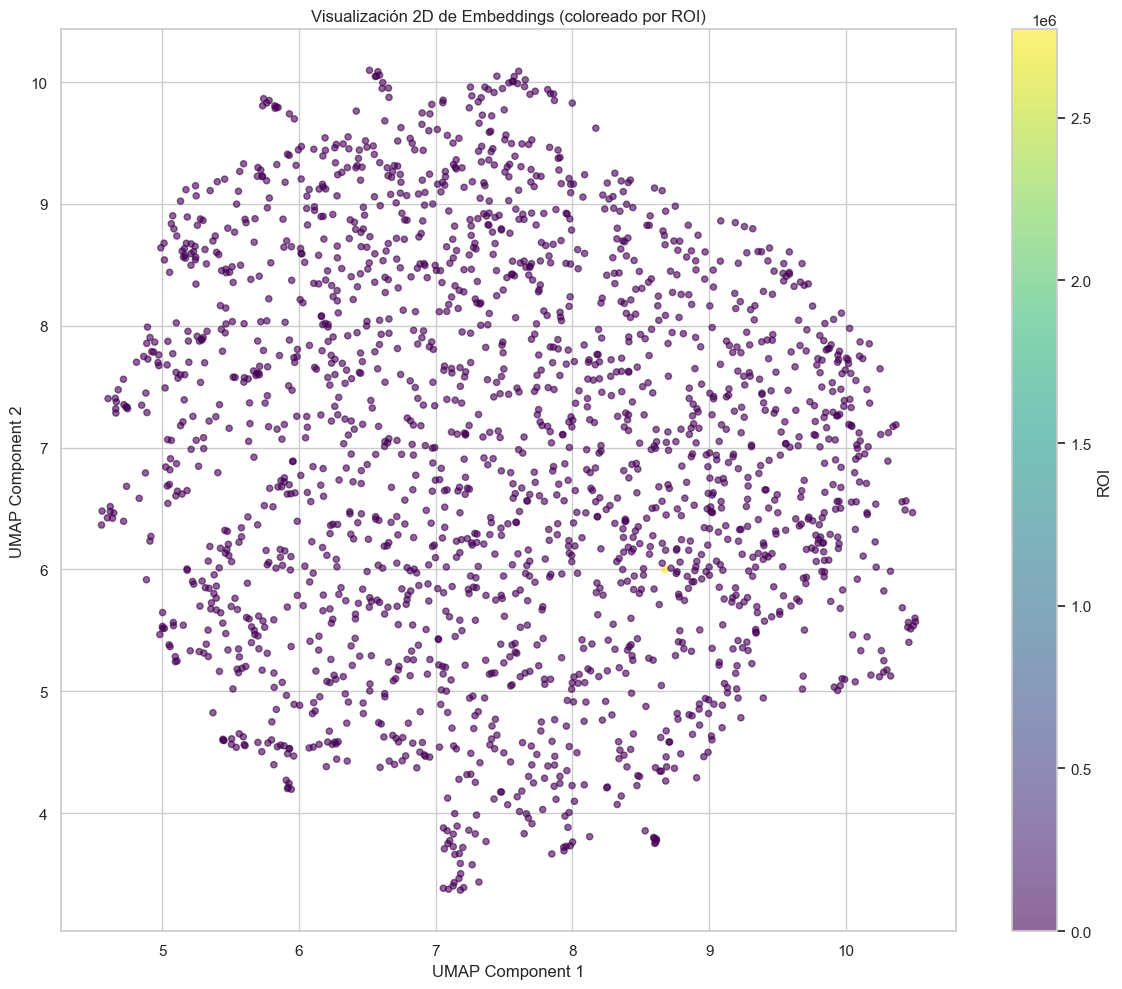

✅ Embeddings reducidos para clustering: (2000, 50)


In [28]:
if 'embeddings_array' in locals() and len(embeddings_array) > 0:
    print("🔄 Aplicando UMAP para reducción de dimensionalidad...")
    
    # Reducir a 2D para visualización
    reducer_2d = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        random_state=42,
        metric='cosine'
    )
    
    embeddings_2d = reducer_2d.fit_transform(embeddings_array)
    
    print(f"✅ Reducción completada: {embeddings_array.shape} -> {embeddings_2d.shape}")
    
    # Visualizar en 2D
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                         c=df_embeddings_valid['roi'], cmap='viridis', 
                         alpha=0.6, s=20)
    plt.colorbar(scatter, label='ROI')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
    plt.title('Visualización 2D de Embeddings (coloreado por ROI)')
    plt.tight_layout()
    plt.show()
    
    # Reducir a dimensiones más bajas para clustering (opcional, usar originales también)
    reducer_clustering = umap.UMAP(
        n_components=50,  # Reducir a 50 dimensiones para clustering más eficiente
        n_neighbors=15,
        min_dist=0.1,
        random_state=42,
        metric='cosine'
    )
    embeddings_reduced = reducer_clustering.fit_transform(embeddings_array)
    print(f"✅ Embeddings reducidos para clustering: {embeddings_reduced.shape}")
else:
    print("⚠️ No hay embeddings disponibles")
    if 'embeddings_array' in locals():
        embeddings_reduced = embeddings_array
    else:
        embeddings_reduced = None


### Clustering con HDBSCAN

HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) se utiliza para identificar grupos temáticos de películas basados en la similitud semántica de sus embeddings.


🔄 Aplicando HDBSCAN para clustering...
✅ Clustering completado:
   Número de clusters: 9
   Puntos de ruido: 1085 (54.2%)
   Distribución de clusters:
     Cluster 0: 34 películas
     Cluster 1: 153 películas
     Cluster 2: 24 películas
     Cluster 3: 22 películas
     Cluster 4: 47 películas
     Cluster 5: 47 películas
     Cluster 6: 327 películas
     Cluster 7: 23 películas
     Cluster 8: 238 películas


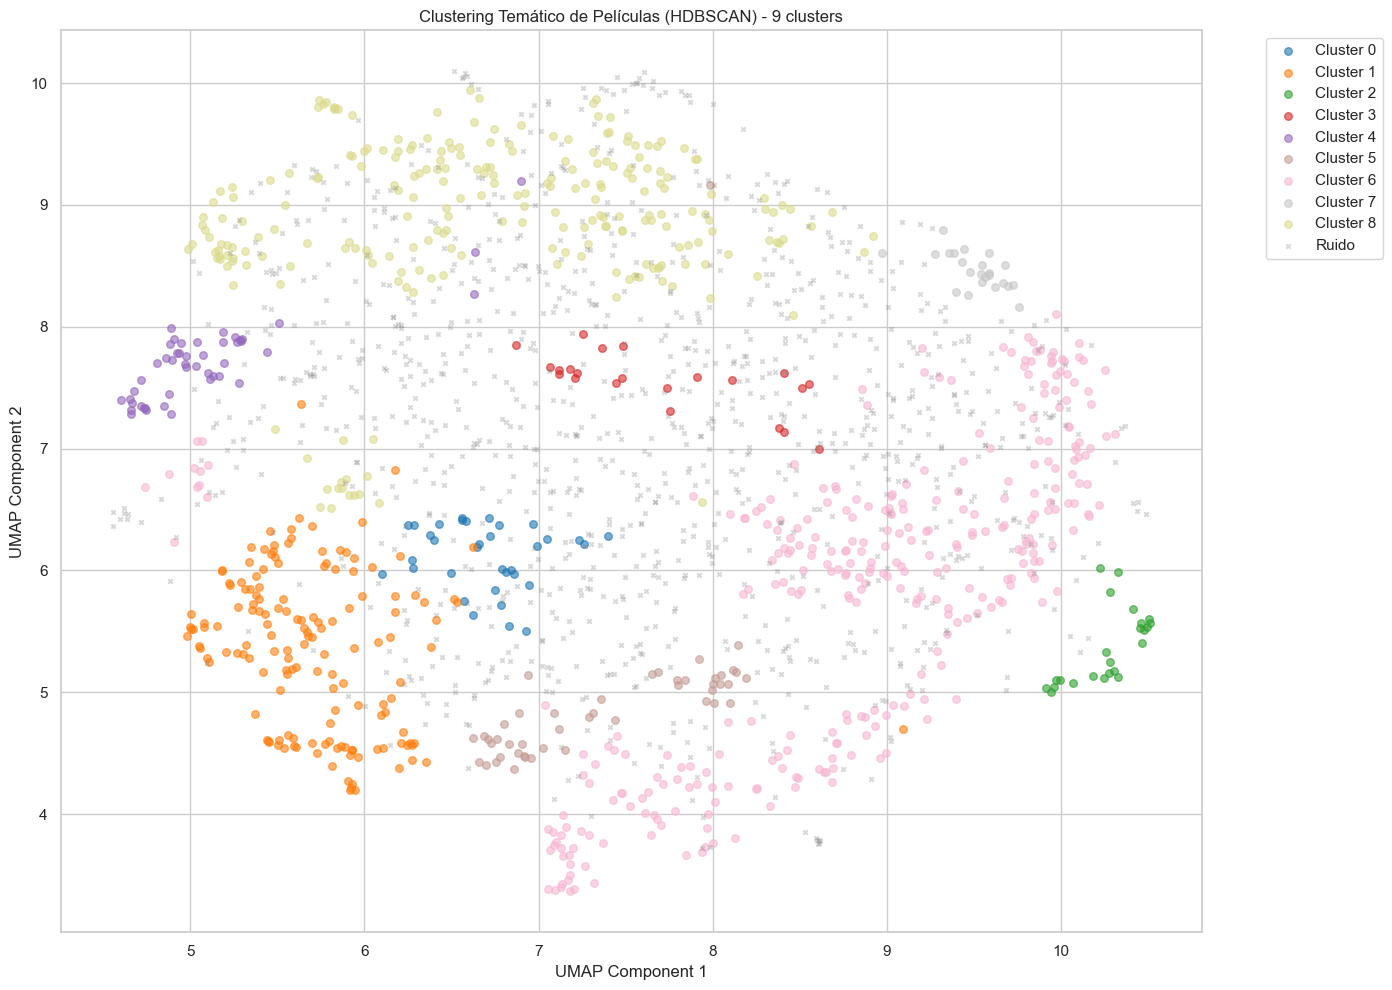

In [30]:
if embeddings_reduced is not None:
    print("🔄 Aplicando HDBSCAN para clustering...")
    
    # Clustering con HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=20,
        min_samples=10,
        cluster_selection_epsilon=0.0,
        metric='euclidean',
        prediction_data=True
    )
    
    cluster_labels = clusterer.fit_predict(embeddings_reduced)
    
    # Estadísticas de clustering
    unique_clusters = sorted([c for c in np.unique(cluster_labels) if c >= 0])
    n_clusters = len(unique_clusters)
    n_noise = np.sum(cluster_labels == -1)
    
    print(f"✅ Clustering completado:")
    print(f"   Número de clusters: {n_clusters}")
    print(f"   Puntos de ruido: {n_noise} ({n_noise/len(cluster_labels)*100:.1f}%)")
    print(f"   Distribución de clusters:")
    for cluster_id in unique_clusters[:10]:  # Mostrar primeros 10
        count = np.sum(cluster_labels == cluster_id)
        print(f"     Cluster {cluster_id}: {count} películas")
    
    # Visualizar clusters en 2D (si tenemos embeddings_2d)
    if 'embeddings_2d' in locals():
        plt.figure(figsize=(14, 10))
        
        # Colores para clusters
        colors = plt.cm.tab20(np.linspace(0, 1, n_clusters + 1))
        
        # Plotear cada cluster
        for i, cluster_id in enumerate(unique_clusters):
            mask = cluster_labels == cluster_id
            plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1],
                       c=[colors[i]], label=f'Cluster {cluster_id}', 
                       alpha=0.6, s=30)
        
        # Plotear ruido
        if n_noise > 0:
            noise_mask = cluster_labels == -1
            plt.scatter(embeddings_2d[noise_mask, 0], embeddings_2d[noise_mask, 1],
                       c='gray', label='Ruido', alpha=0.3, s=10, marker='x')
        
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.title(f'Clustering Temático de Películas (HDBSCAN) - {n_clusters} clusters')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
    # Agregar labels de cluster al dataframe
    df_embeddings_valid['cluster'] = cluster_labels
    
else:
    print("⚠️ No hay embeddings disponibles para clustering")
    cluster_labels = None


### Análisis de clusters

Se analizan las características de cada cluster identificado, incluyendo estadísticas de ROI, géneros más comunes y películas representativas.


📊 Estadísticas por Cluster:


,cluster_id,n_movies,roi_mean,roi_median,roi_std,budget_mean,revenue_mean,vote_average_mean,top_genres
6,6,327,8481.670969,2.373719,153267.017044,5.228363e+07,2.005761e+08,6.739694,"Comedy, Fantasy, Adventure"
4,4,47,35.037909,1.446526,159.121581,2.134114e+07,7.340605e+07,6.403043,"Action, Drama, Thriller"
9,-1,1085,8.347825,1.790452,126.310081,4.569448e+07,1.576322e+08,6.763619,Ruido
7,7,23,8.251940,3.429888,12.327265,2.022693e+07,1.153970e+08,6.703391,"Drama, Romance, Thriller"
3,3,22,6.361209,1.764437,14.012953,2.605000e+07,8.868276e+07,7.006318,"Drama, Comedy, Music"
1,1,153,4.995826,1.913673,19.963148,9.135560e+07,3.119147e+08,6.675307,"Science Fiction, Action, Adventure"
2,2,24,4.981513,2.414759,6.710819,5.230646e+07,2.819995e+08,6.545375,"Fantasy, Horror, Action"
5,5,47,4.464650,2.197325,13.472138,6.133430e+07,2.219503e+08,6.751298,"Family, Comedy, Adventure"
8,8,238,3.102755,1.666569,5.363629,5.000554e+07,1.446073e+08,6.868756,"Thriller, Action, Crime"
0,0,34,1.349666,0.557158,3.546939,5.993245e+07,1.102710e+08,6.968265,"Science Fiction, Action, Drama"


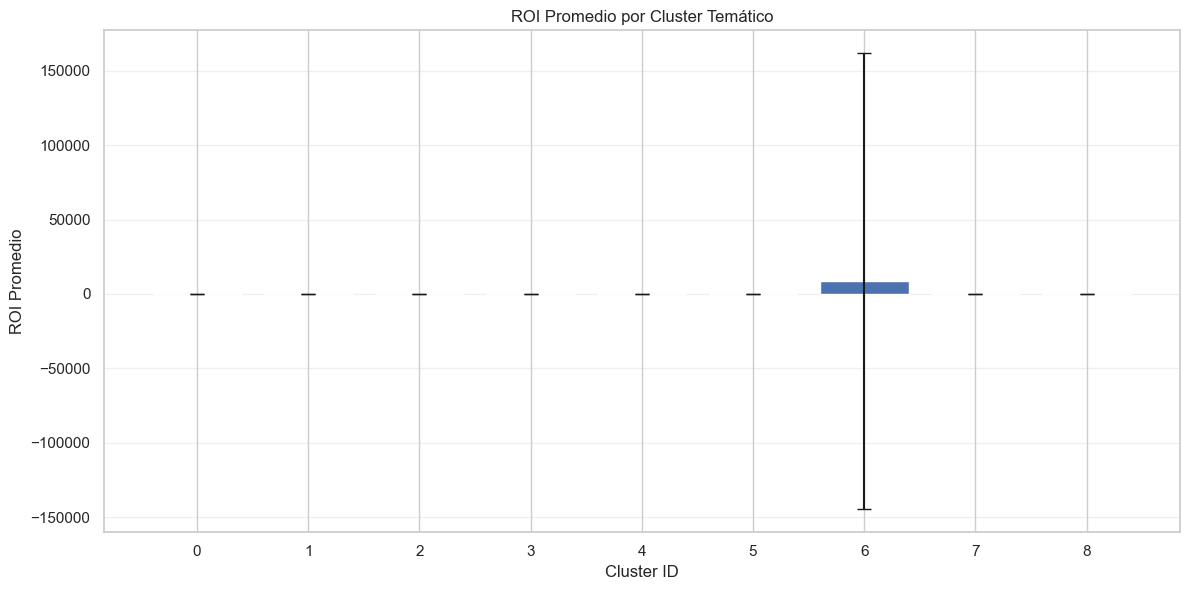


🎬 Películas representativas por cluster (Top 3 por ROI):

Cluster 0 (ROI medio: 1.35):


,title,genres,roi,budget,revenue
1811,The Passion of the Christ,Drama,19.335449,30000000,610063468
69,About Time,"Fantasy, Romance, Drama",6.258371,12000000,87100449
168,The Final Destination,"Mystery, Horror",3.684616,40000000,187384627



Cluster 1 (ROI medio: 5.00):


,title,genres,roi,budget,revenue
1514,King Kong vs. Godzilla,"Adventure, Science Fiction, Fantasy, Comedy, A...",224.000000,12000,2700000
275,E.T. the Extra-Terrestrial,"Science Fiction, Fantasy, Adventure, Family",74.934039,10500000,797307407
401,Jaws,"Adventure, Horror, Thriller",66.236143,7000000,470653000



Cluster 2 (ROI medio: 4.98):


,title,genres,roi,budget,revenue
882,Pretty Woman,"Comedy, Romance",32.100448,14000000,463406268
1920,The Twilight Saga: New Moon,"Drama, Adventure, Romance, Fantasy",13.196549,50000000,709827462
681,Twilight,"Fantasy, Drama, Romance",9.638292,37000000,393616788



Cluster 3 (ROI medio: 6.36):


,title,genres,roi,budget,revenue
1995,Teen Wolf,"Comedy, Fantasy, Romance",65.666667,1200000,80000000
1598,Wonder,"Family, Drama",14.751297,20000000,315025930
138,Whiplash,"Music, Drama",14.244692,3300000,50307484



Cluster 4 (ROI medio: 35.04):


,title,genres,roi,budget,revenue
1149,Fist of Fury,"Action, Drama, Thriller",999.000000,100000,100000000
935,Enter the Dragon,Action,469.588235,850000,400000000
1585,Bloodsport,"Thriller, Drama, Action",42.333333,1500000,65000000


In [31]:
if cluster_labels is not None and 'cluster' in df_embeddings_valid.columns:
    # Calcular estadísticas por cluster
    cluster_stats = []
    
    unique_clusters = sorted([c for c in np.unique(cluster_labels) if c >= 0])
    
    for cluster_id in unique_clusters:
        cluster_movies = df_embeddings_valid[df_embeddings_valid['cluster'] == cluster_id]
        
        # Géneros más comunes
        all_genres = []
        for genres_str in cluster_movies['genres'].dropna():
            if isinstance(genres_str, str):
                all_genres.extend([g.strip() for g in genres_str.split(',')])
        top_genres = pd.Series(all_genres).value_counts().head(3)
        
        stats = {
            'cluster_id': cluster_id,
            'n_movies': len(cluster_movies),
            'roi_mean': cluster_movies['roi'].mean(),
            'roi_median': cluster_movies['roi'].median(),
            'roi_std': cluster_movies['roi'].std(),
            'budget_mean': cluster_movies['budget'].mean(),
            'revenue_mean': cluster_movies['revenue'].mean(),
            'vote_average_mean': cluster_movies['vote_average'].mean(),
            'top_genres': ', '.join(top_genres.index.tolist())
        }
        cluster_stats.append(stats)
    
    # Agregar estadísticas de ruido si existe
    noise_movies = df_embeddings_valid[df_embeddings_valid['cluster'] == -1]
    if len(noise_movies) > 0:
        stats = {
            'cluster_id': -1,
            'n_movies': len(noise_movies),
            'roi_mean': noise_movies['roi'].mean(),
            'roi_median': noise_movies['roi'].median(),
            'roi_std': noise_movies['roi'].std(),
            'budget_mean': noise_movies['budget'].mean(),
            'revenue_mean': noise_movies['revenue'].mean(),
            'vote_average_mean': noise_movies['vote_average'].mean(),
            'top_genres': 'Ruido'
        }
        cluster_stats.append(stats)
    
    df_cluster_stats = pd.DataFrame(cluster_stats)
    
    print("📊 Estadísticas por Cluster:")
    display(df_cluster_stats.sort_values('roi_mean', ascending=False))
    
    # Visualizar ROI por cluster
    plt.figure(figsize=(12, 6))
    clusters_to_plot = [c for c in unique_clusters if c >= 0]
    roi_means = [df_cluster_stats[df_cluster_stats['cluster_id'] == c]['roi_mean'].values[0] 
                 for c in clusters_to_plot]
    roi_stds = [df_cluster_stats[df_cluster_stats['cluster_id'] == c]['roi_std'].values[0] 
                for c in clusters_to_plot]
    
    plt.bar(range(len(clusters_to_plot)), roi_means, yerr=roi_stds, capsize=5)
    plt.xlabel('Cluster ID')
    plt.ylabel('ROI Promedio')
    plt.title('ROI Promedio por Cluster Temático')
    plt.xticks(range(len(clusters_to_plot)), clusters_to_plot)
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Mostrar películas representativas de algunos clusters
    print("\n🎬 Películas representativas por cluster (Top 3 por ROI):")
    for cluster_id in unique_clusters[:5]:  # Primeros 5 clusters
        cluster_movies = df_embeddings_valid[df_embeddings_valid['cluster'] == cluster_id]
        top_movies = cluster_movies.nlargest(3, 'roi')[['title', 'genres', 'roi', 'budget', 'revenue']]
        print(f"\nCluster {cluster_id} (ROI medio: {df_cluster_stats[df_cluster_stats['cluster_id'] == cluster_id]['roi_mean'].values[0]:.2f}):")
        display(top_movies)
else:
    print("⚠️ No hay clusters disponibles para análisis")


In [32]:
# Guardar modelos entrenados
import joblib

# Guardar modelo de ROI
joblib.dump(model_roi, 'modelo_roi.joblib')
print('✅ Modelo de ROI guardado como modelo_roi.joblib')

# Guardar modelo de Revenue
joblib.dump(model_rev, 'modelo_revenue.joblib')
print('✅ Modelo de Revenue guardado como modelo_revenue.joblib')

# Guardar modelo de Rentabilidad
joblib.dump(model_prof, 'modelo_rentabilidad.joblib')
print('✅ Modelo de Rentabilidad guardado como modelo_rentabilidad.joblib')

# Guardar feature engineer
joblib.dump(feature_engineer, 'feature_engineer.joblib')
print('✅ Feature Engineer guardado como feature_engineer.joblib')


✅ Modelo de ROI guardado como modelo_roi.joblib
✅ Modelo de Revenue guardado como modelo_revenue.joblib
✅ Modelo de Rentabilidad guardado como modelo_rentabilidad.joblib
✅ Feature Engineer guardado como feature_engineer.joblib


## 🛫 Cierre de la entrega: Reflexiones finales

Los modelos implementados proporcionan una base sólida para la predicción del éxito comercial de películas. Aunque hay margen de mejora, los resultados demuestran que:

1. **Las características disponibles son predictivas**: Los modelos capturan patrones significativos
2. **Random Forest es apropiado**: Maneja bien la mezcla de variables categóricas y numéricas
3. **Los embeddings permiten clustering temático**: Identifican grupos de películas con contenido similar
4. **El enfoque es escalable**: La arquitectura permite agregar más datos y características

La implementación actual sirve como punto de partida para un sistema de recomendación y análisis más sofisticado en la industria cinematográfica.
